In [2]:
%run ../talktools.py

# Fitting a Straight Line to (Fake) Data using pystan

**AY128/256 UC Berkeley**

(4/1/2019)

## Practical Example with
* pystan


For this example, you'll need to have `pystan`, `corner` and `pandas' installed.

```bash
pip install corner pystan pandas
```

In [3]:
from __future__ import print_function, division
%matplotlib inline
import os   # need this to get pystan working on laptop
os.environ['MACOSX_DEPLOYMENT_TARGET'] = '10.9' # need this to get pystan working on laptop
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pystan
import arviz
#sns.set_style("whitegrid")
#sns.set_context("poster")

## Make a Fake Dataset

* N data points 
* Linear model : $y = mx + b$

In [4]:
Ndata = 10 # number of data points
m_true = 3 # true slope
b_true = -2 # true intercept

## Add Gaussian Noise to the fake data

* Compute our model: $y = mx + b$
* Compute error bars, by randomly drawing them from a uniform distribution [0.1,0.7]
* Assume that each data point $y$ is the mean of a normal distribution and that error bar is the standard deviation
* Then we can resample the model to make it look noisy

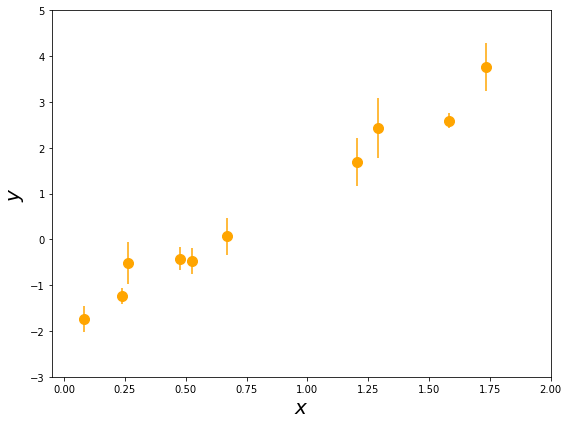

In [5]:
# set the random seed
seed =   128  
rnd = np.random.RandomState(seed)

# create a set of x points with length N data from a uniform distritubion
xmin, xmax = 0, 2
x = rnd.uniform(xmin, xmax, Ndata)
x.sort()  # sort them in place

# create noiseless fake y data using x and true slope and intercept
y_data = m_true * x + b_true

# create y error bars from a uniform distribution
y_err_min, y_err_max = 0.1, 0.7
y_err = rnd.uniform(y_err_min, y_err_max, Ndata)

# add Gaussian noise to fake y data by re-sampling
# assume each noiseless y data point (from above) and y_err are the mean
# and standard deviation of a normal distribution
# use this to make noisy data
y_data = rnd.normal(y_data, y_err)

# plot the data
plt.figure(figsize=(8,6))
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=10, c='orange')
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xlim(-0.05, 2)
plt.ylim(-3, 5)
plt.tight_layout()

## Add Gaussian Noise to the fake data

### Set up the model in pystan
* needs to be written in specific format native to stan
* __data__: define the data
* __parameters__: define model parameters to be fit
* __transformed parameters__: we're fitting a combination of the parameters (i.e., y=mx+b), not the parameters themselves
* __model__: specify the of distributions governing each parameter and the data model (i.e., likelihood function)

In [6]:
stan_code = """
data {{
// define the data within Stan
int<lower=0> N;           // number of data points    
real x[N];                // x values             
real y[N];               // y values            
real<lower=0> sigma[N];  // y error bars
}}
parameters {{
// model parameters
real m;                 //  slope of line              
real b;                 //  y-intercept     
}}
transformed parameters{{
// construct the model (i.e., theta=mx+b)
real theta[N];
for (j in 1:N)
theta[j] = m * x[j] + b;      
}}
model {{
m ~ normal({m_mean}, {m_sigma});     // slope has a normal distribution 
b ~ uniform({b_lower}, {b_upper});   // y-intercept has a uniform distribution
y ~ normal(theta, sigma);            // data points have a normal distribution -> Gaussian likelihood function
}}
"""

# set the data
linear_data = {'N': Ndata,
               'x': x,
               'y': y_data,
               'sigma': y_err } 

# set prior characteristics 
stan_dict = {}
stan_dict['m_mean'] = 0.0
stan_dict['m_sigma'] = 5.0
stan_dict['b_lower'] = -5
stan_dict['b_upper'] = 5


Nsamples = 1000 # number of samples
warmup = 500 # number of burn in samples (stan default is half of Nsamples)
chains = 4 # number of chains
thin = 1 # discard every n=thin samples in the end 
seed = 128 # random seed for starting the chain

# create the model
sm = pystan.StanModel(model_code=stan_code.format(**stan_dict))

# run the model
fit = sm.sampling(data=linear_data, iter=Nsamples, chains=chains, warmup=warmup, thin=thin, seed=seed)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb482e46817480e3ed71eb32fdc8619f NOW.


## Look at some outputs from the fit

A corner plot:

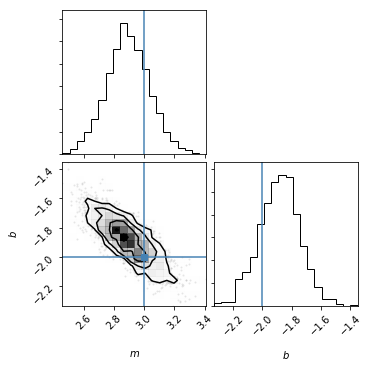

In [7]:
import corner  # import corner
la = fit.extract(permuted=True)   # fit contains all information on chains
postsamples = np.vstack((la['m'], la['b'])).T  # pull out parameters of interest and reshape them
fig = corner.corner(postsamples, labels=[r"$m$", r"$b$"], truths=[m_true, b_true])  # let's make a corner plot

## Let's do a posterior predictive check

Plot draws from the posterior on top of the data

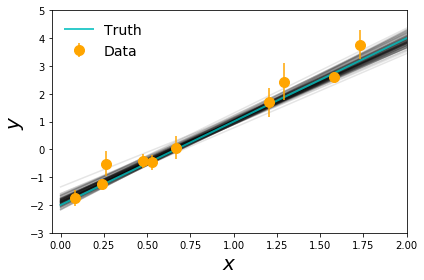

In [8]:
# create an array of x values
xl = np.array([0, 2])

# randomly draw 100 points from my posterior (i.e., the MCMC chain)
# and plot them as thin black lines
for m, b in postsamples[np.random.randint(len(la['m']), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)

# plot the true model from the very beginning
plt.plot(xl, m_true*xl+b_true, color="c", lw=2, alpha=0.8, label='Truth')

# plot the fake data with error bars
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=10, c='orange', label='Data', zorder=10)

#set some limits on the plot
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xlim(-0.05, 2)
plt.ylim(-3,5)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()

In [9]:
#compute summary statistics: 50, 16, 84 percentiles

m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(postsamples, [16, 50, 84],
                                                axis=0)))
print(f"true m value: {m_true}")
print(f"mcmc median, +/- for m: {m_mcmc}\n")

print(f"true b value: {b_true}")
print(f"mcmc median, +/- for b: {b_mcmc}")
# note to self: figure out correct way to format f-strings + latex

true m value: 3
mcmc median, +/- for m: (2.8913179871816497, 0.14215204451923125, 0.13725459984397492)

true b value: -2
mcmc median, +/- for b: (-1.8797513753198993, 0.12910057485697068, 0.14064746511542747)


## Other possibilities: import fit into pandas framework and look at summary statistics

In [10]:
import pandas as pd

# fit.summary is a dictionary that stores a number of interesting parameters related to your fit
summary_dict = fit.summary()

# import it into pandas to play around with
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# for example, we can look at the median and 2-sigma equivalent uncertainty ranges
m_med, b_med = df['50%']['m'], df['50%']['b']
m_lower, m_upper = df['2.5%']['m'], df['97.5%']['m']  # 2-sigma errors
b_lower, b_upper = df['2.5%']['b'], df['97.5%']['b']  # 2-sigma errors
print (f"m_true={m_true}, b_true={b_true}")
print(f"m_median={m_med} + {m_upper-m_med} - {m_med - m_lower}")
print(f"b_median={b_med} + {b_upper-b_med} - {b_med - b_lower}")

m_true=3, b_true=-2
m_median=2.8913179871816497 + 0.28574074856134013 - 0.2807265224514035
b_median=-1.8797513753198993 + 0.2625375136838133 - 0.28042284886933055


## pystan features some native plotting capabilitites

something to play around with, if it interests you

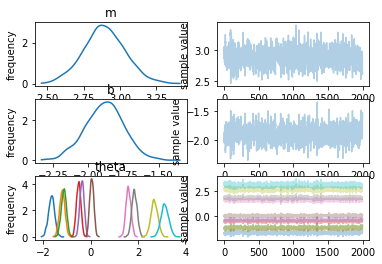

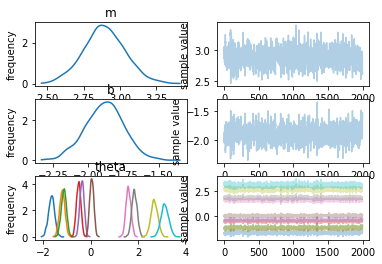

In [11]:
fit.plot()